# **5. ResNet-50**

First of all, let's load the required libraries in order to run the code:

In [4]:
# Base libraries
import os

# Visualization libraries
import matplotlib.pyplot as plt
import seaborn as sns

# Tensorflow
import tensorflow.keras as keras
from tensorflow import debugging as tfdbg
from tensorflow import device
from tensorflow.keras import optimizers
from tensorflow.keras import models, layers
from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import load_model
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

# ResNet50
from tensorflow.keras.applications import ResNet50

# Own modules
from src.utils import drop_checkpoints, dataset_stats, plot_metric_curves

d:\venvs\no-estruc\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Now let's see how our data is structured:

In [5]:
# Root folder
base_dir = "./data"

In [6]:
# Train folder
train_dir = os.path.join(base_dir, "train")

# Validation folder
validation_dir = os.path.join(base_dir, "validation")

# Test folder
test_dir = os.path.join(base_dir, "test")

In [7]:
drop_checkpoints(base_dir)

Let's also see how many images there are for each class in the training, validation and test set.

In [8]:
dataset_stats(train_dir, validation_dir, test_dir)

Number of classes: 4
Existing classes: ['Baroque', 'Realism', 'Renaissance', 'Romanticism']

----------------------------------------
Number of images per class and dataset:
----------------------------------------
             Train  Validation  Test
Style                               
Baroque       4000         500   500
Realism       4000         500   500
Renaissance   4000         500   500
Romanticism   4000         500   500


We'll also create the directory, if not created yet, where the models will be saved:

In [9]:
# Create directory where to save the models created
models_dir = "./models"
os.makedirs(models_dir, exist_ok=True)

*Explain dropout and data augmentation, include reference to original paper*

## **5.1 ResNet-50 with frozen convolutional base (just training classifier)**

### 5.1.1. Model structure

Let's first create the model structure:

Firstly, let's define the values of some hyperparameters:

In [10]:
# Define some hyperparameters' values

# Input shape
input_shape = (256, 256,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [11]:
conv_base = ResNet50( 
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=input_shape
)

# Freeze the convolutional base
conv_base.trainable = False

# Create the model
model = models.Sequential()

# Add the convolutional base
model.add(conv_base)

# Add the classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [12]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten (Flatten)           (None, 2048)              0         
                                                                 
 dense (Dense)               (None, 512)               1049088   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                                 
 dense_1 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [13]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['acc']
)

### 5.1.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step...

In [14]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1),
    zoom_range=[0.95, 1.05],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [15]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 256, 256, 3)
Labels batch shape: (128, 4)


*We can appreciate that...*

### 5.1.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to avoid *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training:

In [16]:
# Model name and path
model_path = os.path.join("models", "resnet50_frozen_model.h5")

In [17]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [18]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
 15/125 [==>...........................] - ETA: 26:42 - loss: 5.3926 - acc: 0.2573

d:\venvs\no-estruc\lib\site-packages\PIL\TiffImagePlugin.py:858: UserWarning: Corrupt EXIF data.  Expecting to read 2 bytes but only got 0. 
  warnings.warn(str(msg))


125/125 [==============================] - ETA: 0s - loss: 1.9463 - acc: 0.2911 
Epoch 1: val_loss improved from inf to 1.32225, saving model to models\resnet50_frozen_model.h5
125/125 [==============================] - 1744s 14s/step - loss: 1.9463 - acc: 0.2911 - val_loss: 1.3223 - val_acc: 0.4320
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.3501 - acc: 0.3114 
Epoch 2: val_loss did not improve from 1.32225
125/125 [==============================] - 1543s 12s/step - loss: 1.3501 - acc: 0.3114 - val_loss: 1.3363 - val_acc: 0.4148
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.3525 - acc: 0.3196 
Epoch 3: val_loss did not improve from 1.32225
125/125 [==============================] - 1567s 13s/step - loss: 1.3525 - acc: 0.3196 - val_loss: 1.3725 - val_acc: 0.3633
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 1.3527 - acc: 0.3159 
Epoch 4: val_loss did not improve from 1.32225
125/125 [=========================

Now let's load the best model found:

In [19]:
# load the saved model
saved_model = load_model(model_path)

### 5.1.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [20]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

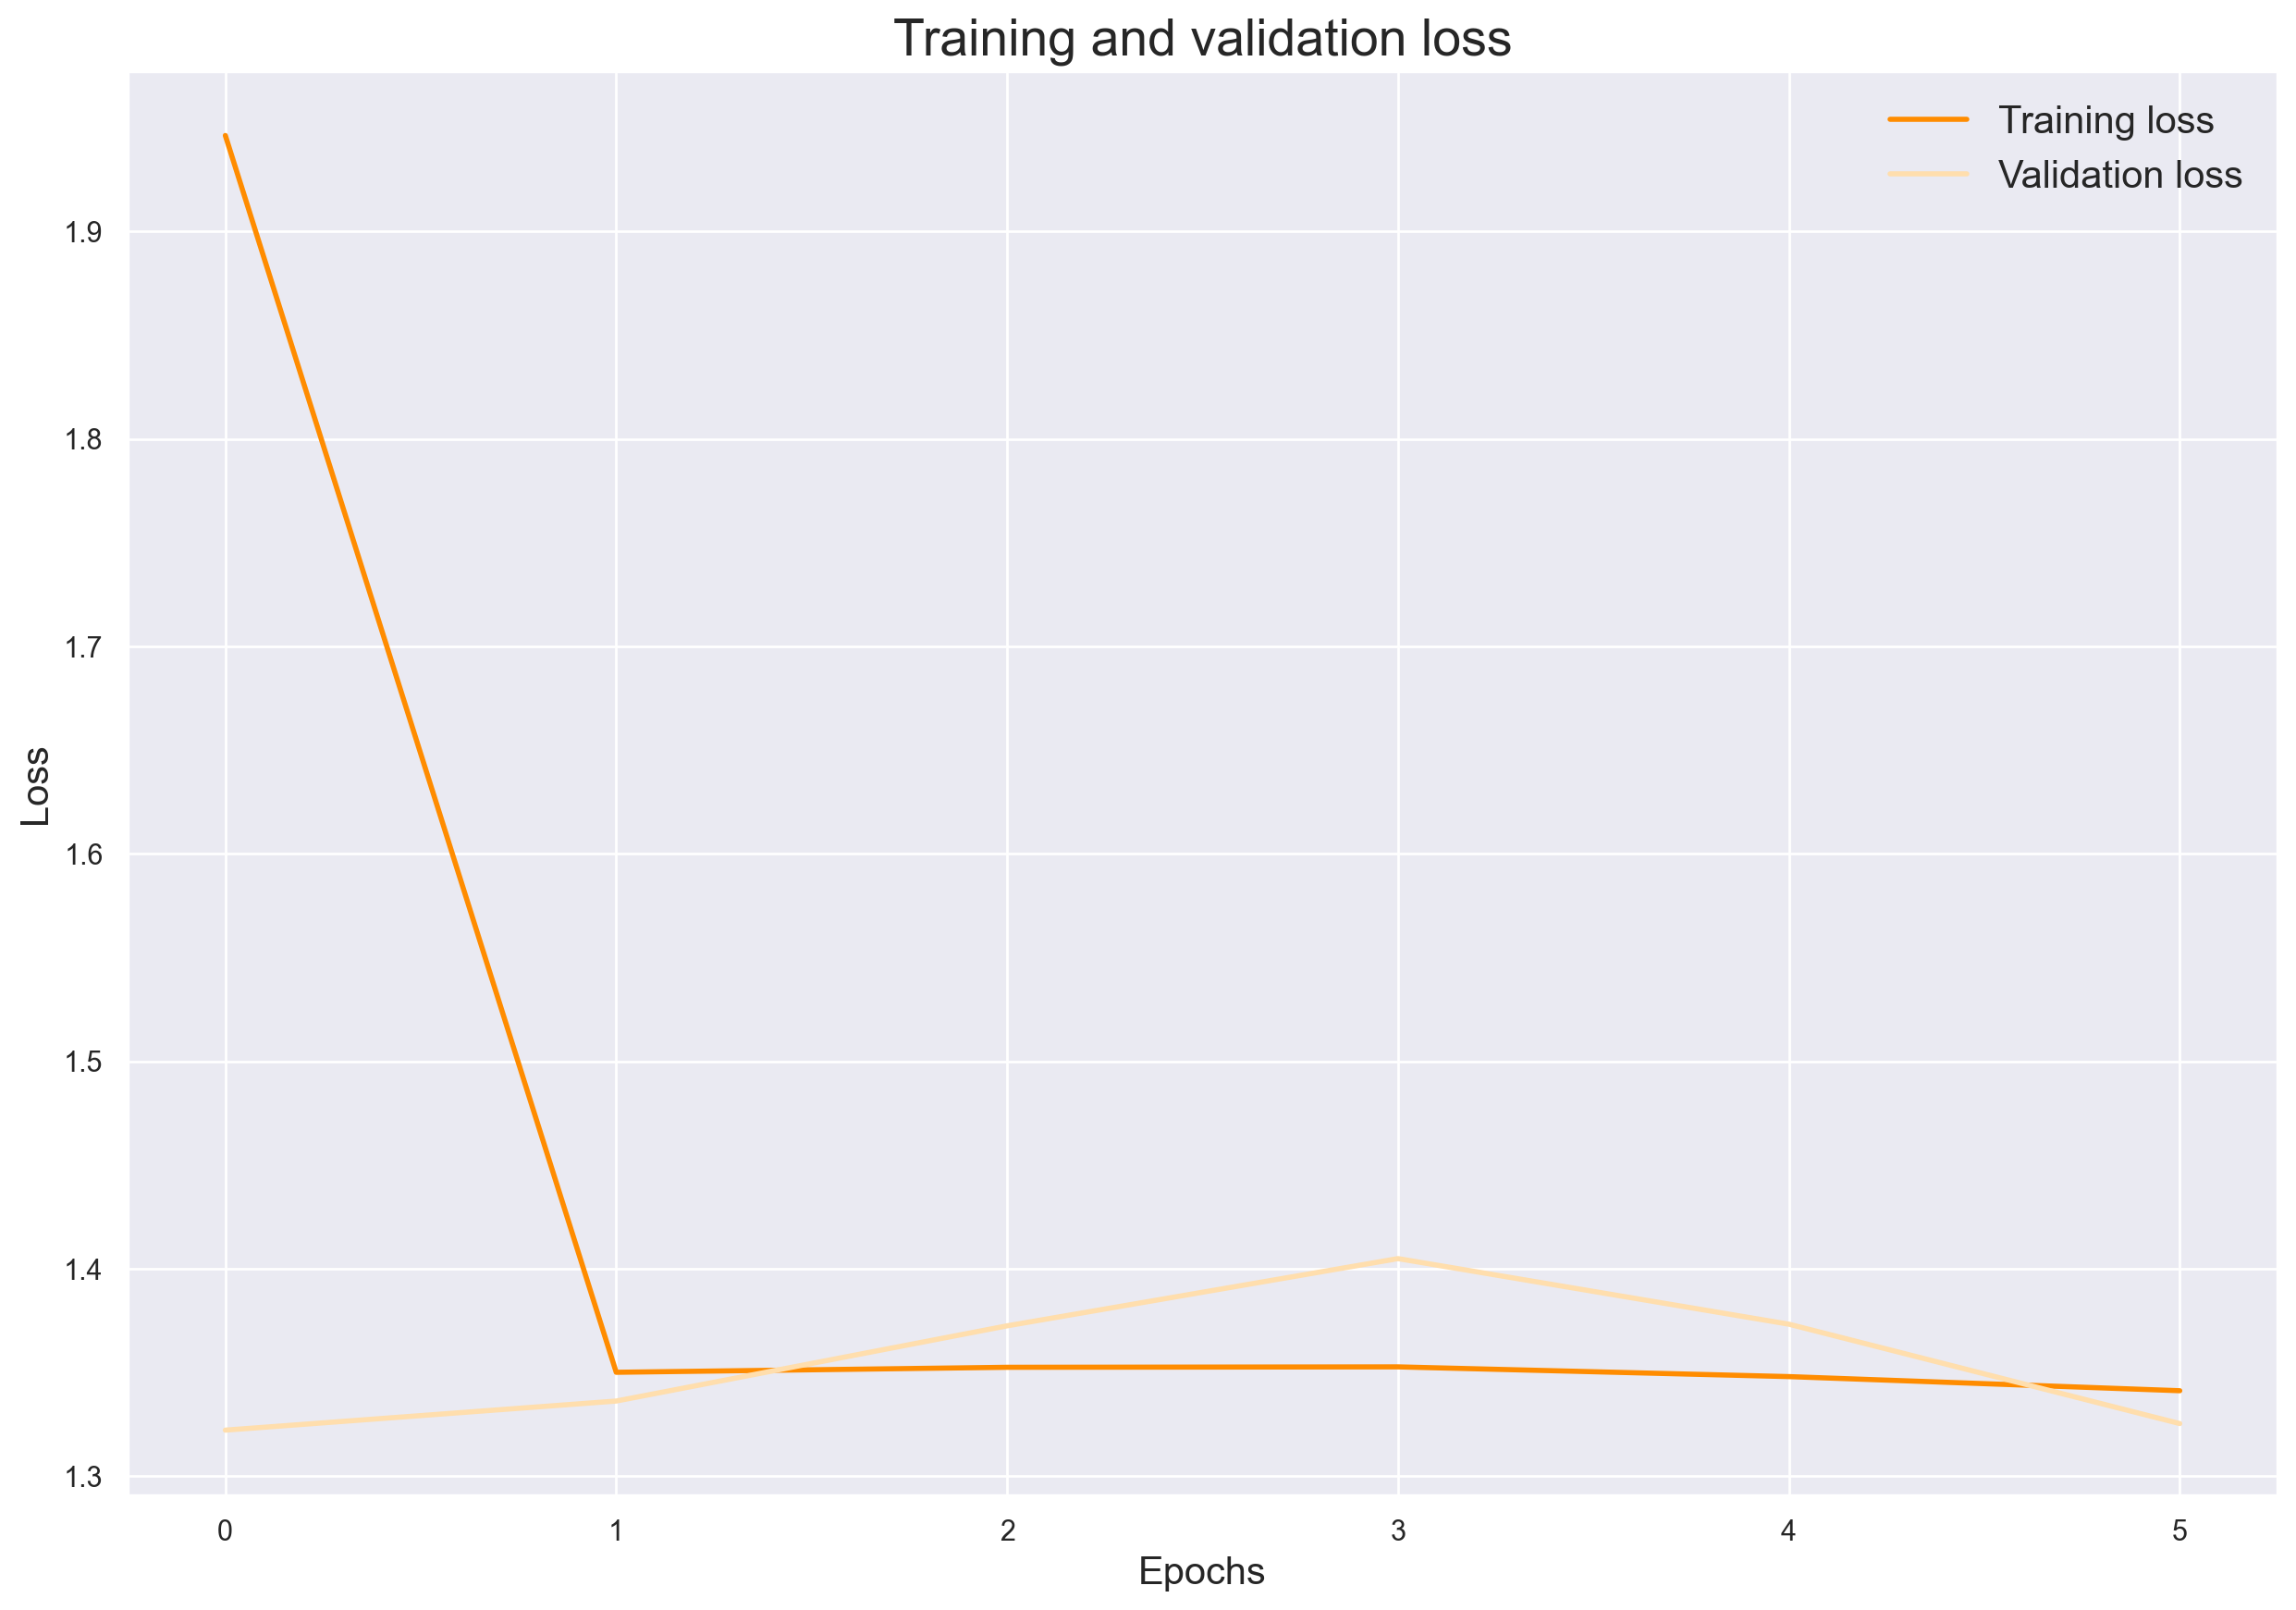

In [21]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "darkorange", "navajowhite", "Loss")

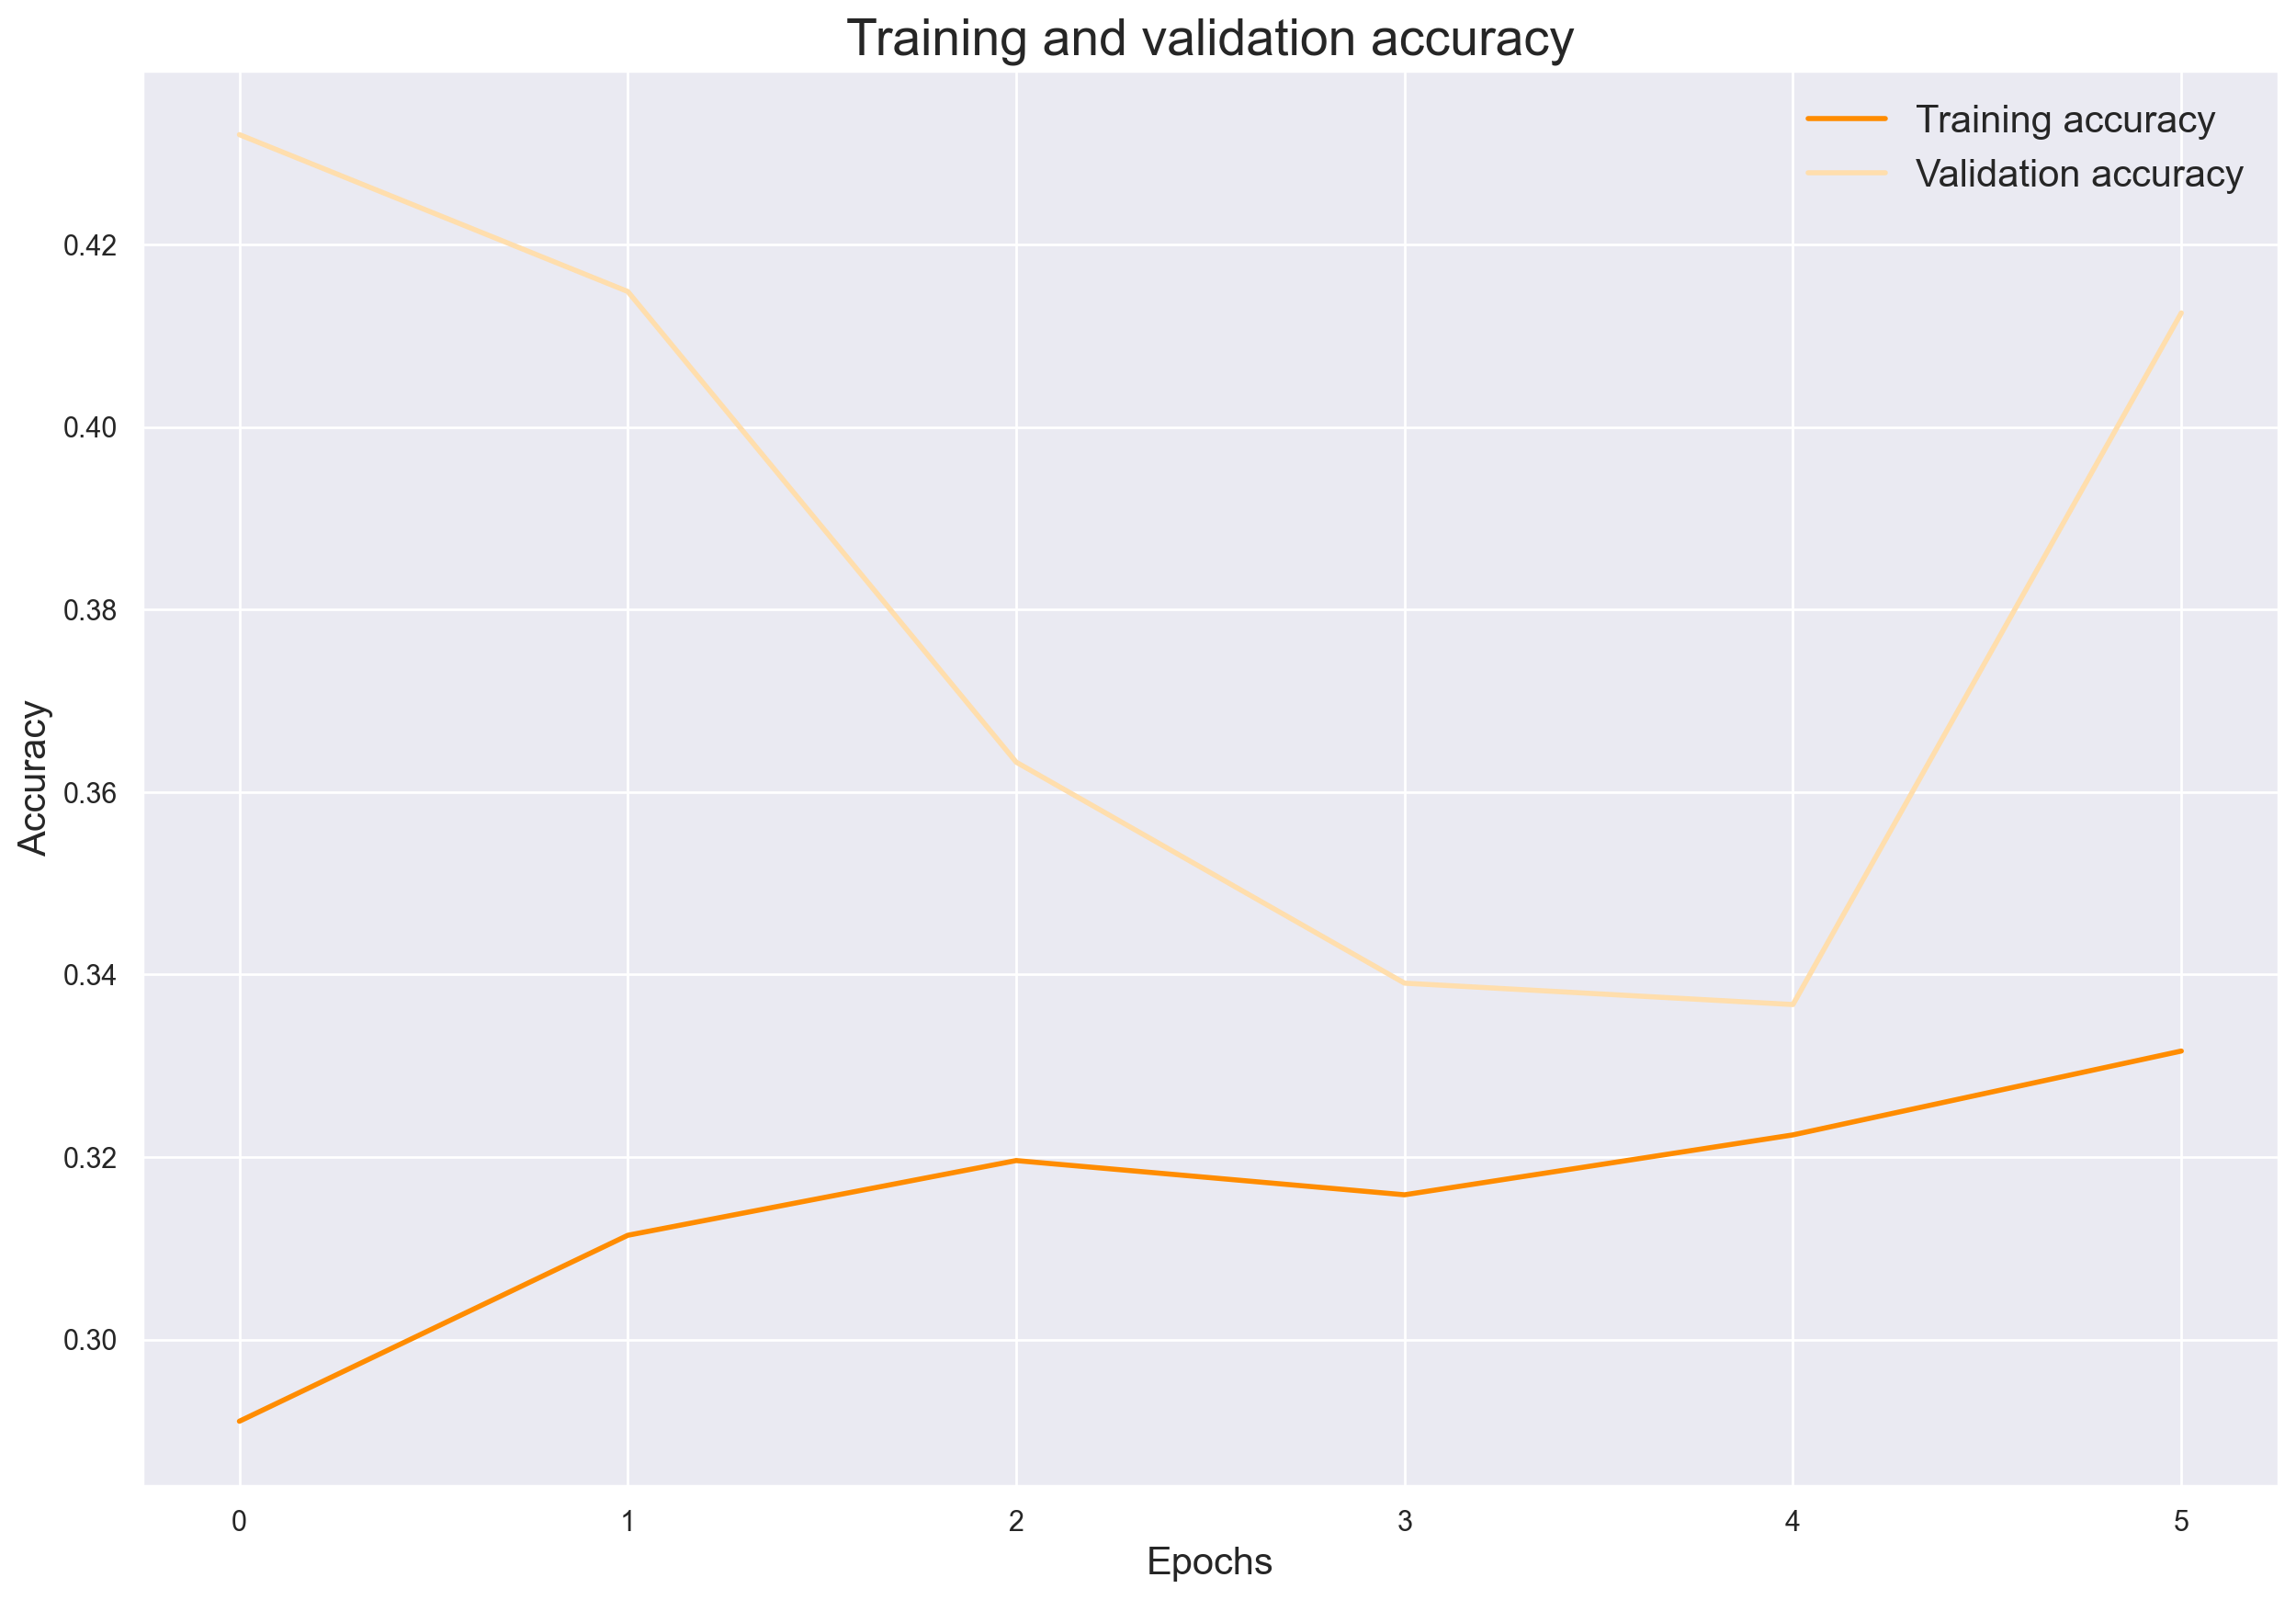

In [22]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "darkorange", "navajowhite", "Accuracy")

In [23]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
)

Found 2000 images belonging to 4 classes.


In [24]:
model.evaluate(test_generator)

50/50 [==============================] - 217s 4s/step - loss: 1.3217 - acc: 0.3565


[1.321739912033081, 0.3564999997615814]

In [25]:
saved_model.evaluate(test_generator)

50/50 [==============================] - 210s 4s/step - loss: 1.3400 - acc: 0.3195


[1.3399921655654907, 0.31949999928474426]

*Comments about how those metrics have evolved...*

## **5.2 ResNet-50 training classifier and last convolutional layer**

### 5.2.1. Model structure

Let's first create the model structure:

Firstly, let's define the values of some hyperparameters:

In [26]:
# Define some hyperparameters' values

# Input shape
input_shape = (256, 256,  3)

# Batch_size and steps per epoch
training_size = sum([len(file) for path, folder, file in os.walk(train_dir)])
batch_size = 128
steps_per_epoch = training_size // batch_size
print(f"Steps per epoch: {steps_per_epoch}")

Steps per epoch: 125


In [27]:
conv_base = ResNet50( 
    include_top=False,
    weights="imagenet",
    pooling="max",
    input_shape=input_shape
    )

# Freeze the convolutional base unless the last layer
conv_base.trainable = False
# Unfreeze the last layer
conv_base.layers[-1].trainable = True

# Create the model
model = models.Sequential()

# Add the convolutional base
model.add(conv_base)

# Add the classifier
model.add(layers.Flatten())
model.add(layers.Dense(512, activation='relu'))
model.add(layers.Dropout(0.5))

# Output layer
model.add(layers.Dense(4, activation='softmax'))

Once the structure of the base model has been defined, let's see exactly how many parameters it has in order to have a better idea of how flexible this model is:

In [28]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_2 (Dense)             (None, 512)               1049088   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 dense_3 (Dense)             (None, 4)                 2052      
                                                                 
Total params: 24,638,852
Trainable params: 1,051,140
Non-trainable params: 23,587,712
_________________________________________________________________


We'll use Adam as our optimizer since it is the most popular optimizer right now, as well as versatile (i.e., it can be used in multiple contexts).

In [29]:
model.compile(
    loss='categorical_crossentropy',
    optimizer=optimizers.Adam(),
    metrics=['acc']
)

### 5.2.2. Data preprocessing

In this case, we will include the Data Augmentation step to the model preprocessing step...

In [30]:
# Apply data augmentation to the training set
# https://towardsdatascience.com/exploring-image-data-augmentation-with-keras-and-tensorflow-a8162d89b844
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=5,
    width_shift_range=0.1,
    height_shift_range=0.1,
    brightness_range=(0.9, 1),
    zoom_range=[0.95, 1.05],
    horizontal_flip=True,
    fill_mode='nearest'
    )

# The data augmentation must not be used for the test set!
# All images will be rescaled by 1./255
test_datagen = ImageDataGenerator(rescale=1./255)

train_generator = train_datagen.flow_from_directory(
        train_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=True
        )

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        # All images will be resized to the dimensions specified
        target_size=input_shape[:2],
        batch_size=batch_size,
        class_mode='categorical',
        shuffle=False
        )

Found 16000 images belonging to 4 classes.
Found 2000 images belonging to 4 classes.


Now let's take a look at the output of one of these generators (for instance, the training one):

In [31]:
for data_batch, labels_batch in train_generator:
    print('Data batch shape:', data_batch.shape)
    print('Labels batch shape:', labels_batch.shape)
    break

Data batch shape: (128, 256, 256, 3)
Labels batch shape: (128, 4)


*We can appreciate that...*

### 5.2.3. Training

Let's train the model:

We use [Early Stopping](https://machinelearningmastery.com/how-to-stop-training-deep-neural-networks-at-the-right-time-using-early-stopping/) to avoid *overfitting*, as well `ModelCheckpoint` to save the best model obtained during training:

In [32]:
# Model name and path
model_path = os.path.join("models", "resnet50_unfrozen_model.h5")

In [33]:
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=5)
mc = ModelCheckpoint(model_path, monitor='val_loss', 
                     mode='min', verbose=1, save_best_only=True)

In [34]:
history = model.fit(
    train_generator,
    steps_per_epoch=steps_per_epoch,
    epochs=30,
    validation_data=validation_generator,
    validation_steps=10,
    callbacks = [es, mc]
)

Epoch 1/30
125/125 [==============================] - ETA: 0s - loss: 1.8821 - acc: 0.2896 
Epoch 1: val_loss improved from inf to 1.37082, saving model to models\resnet50_unfrozen_model.h5
125/125 [==============================] - 1611s 13s/step - loss: 1.8821 - acc: 0.2896 - val_loss: 1.3708 - val_acc: 0.4023
Epoch 2/30
125/125 [==============================] - ETA: 0s - loss: 1.3586 - acc: 0.3050 
Epoch 2: val_loss did not improve from 1.37082
125/125 [==============================] - 1514s 12s/step - loss: 1.3586 - acc: 0.3050 - val_loss: 1.3768 - val_acc: 0.3594
Epoch 3/30
125/125 [==============================] - ETA: 0s - loss: 1.3453 - acc: 0.3276 
Epoch 3: val_loss improved from 1.37082 to 1.35190, saving model to models\resnet50_unfrozen_model.h5
125/125 [==============================] - 1532s 12s/step - loss: 1.3453 - acc: 0.3276 - val_loss: 1.3519 - val_acc: 0.3945
Epoch 4/30
125/125 [==============================] - ETA: 0s - loss: 1.3339 - acc: 0.3322 
Epoch 4: val_

Now let's load the best model found:

In [35]:
# load the saved model
saved_model = load_model(model_path)

### 5.2.4. Validation

Let's plot how the loss and the accuracy from both training and validations sets have evolved during the training process. 

In [36]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

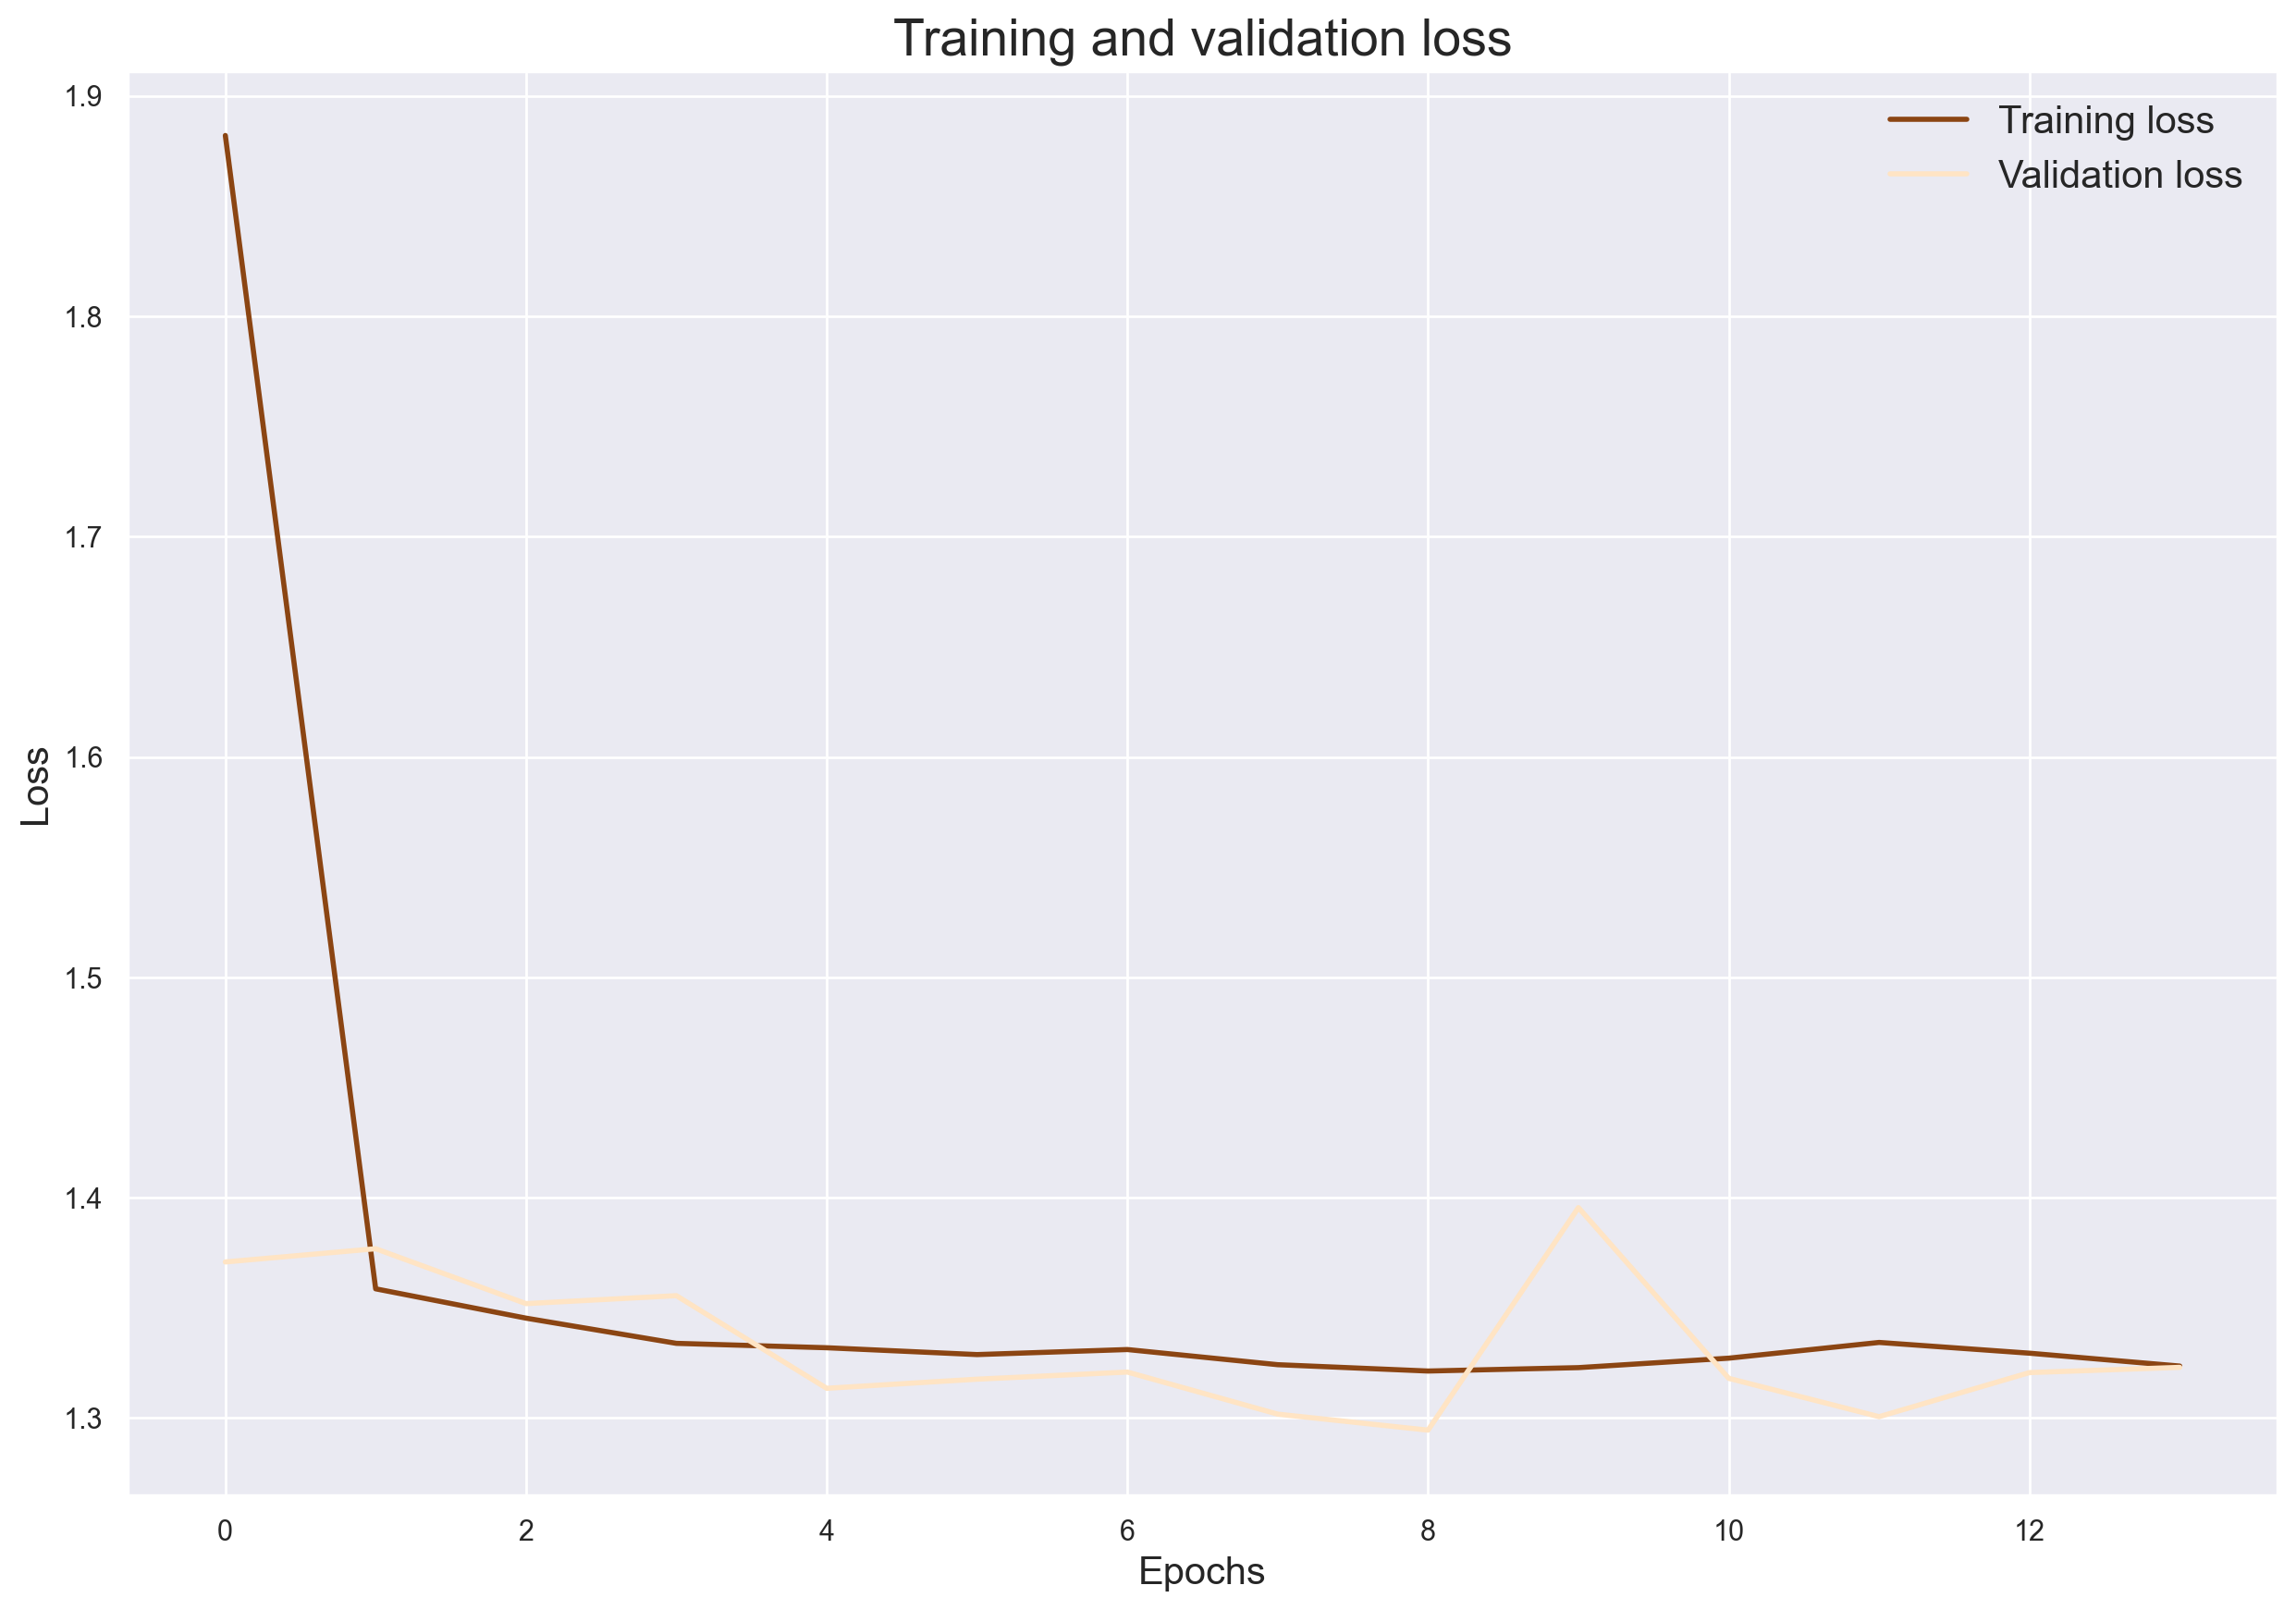

In [37]:
# Plot loss curves
plot_metric_curves(epochs, loss, val_loss, "saddlebrown", "bisque", "Loss")

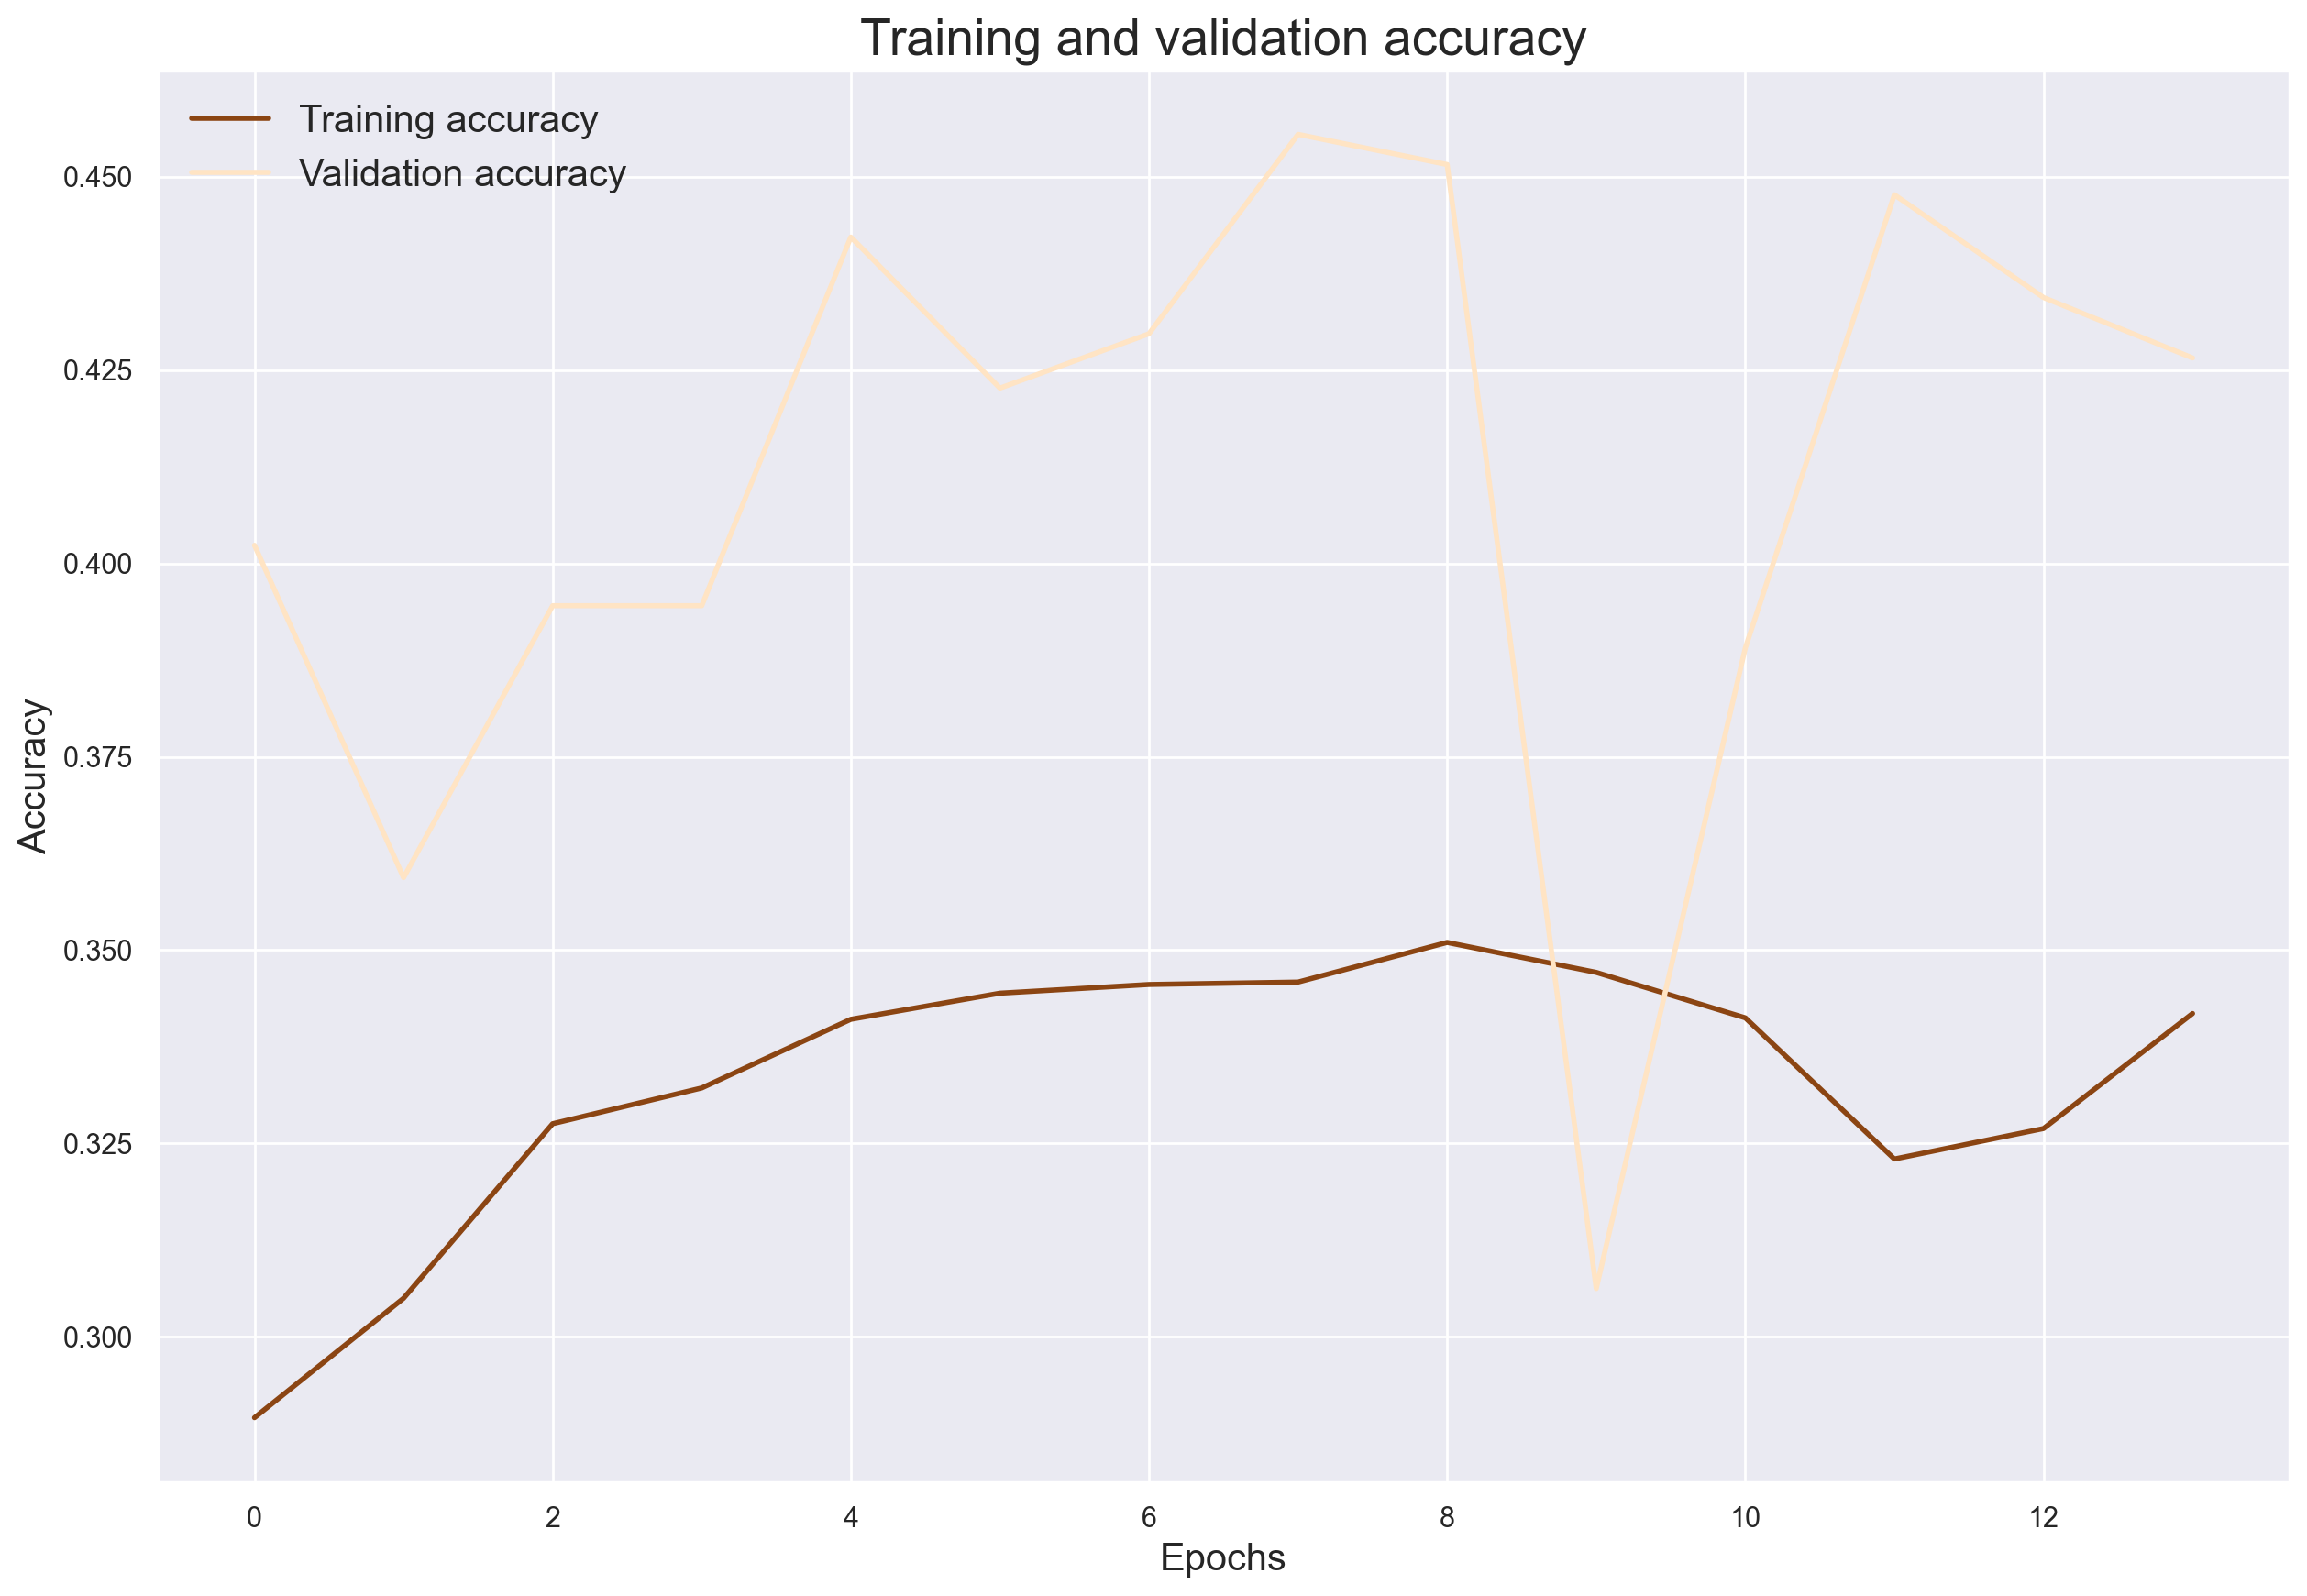

In [38]:
# Plot accuracy curves
plot_metric_curves(epochs, acc, val_acc, "saddlebrown", "bisque", "Accuracy")

In [39]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=input_shape[:2],
        batch_size=40,
        class_mode='categorical',
        shuffle=False
        )

Found 2000 images belonging to 4 classes.


In [40]:
model.evaluate(test_generator)

50/50 [==============================] - 166s 3s/step - loss: 1.2867 - acc: 0.4045


[1.2866849899291992, 0.40450000762939453]

In [41]:
saved_model.evaluate(test_generator)

50/50 [==============================] - 165s 3s/step - loss: 1.2818 - acc: 0.4070


[1.2818458080291748, 0.40700000524520874]

*Comments about how those metrics have evolved...*